## Robot programming workshop 05

<div class="alert alert-block alert-info">For this workshop you will be using a new robot, the dr20, and a new environment, a short 'maze' with a curvy path to get gent out. The dr20 robot had a richer array of sensors than the line-following robot, with <b>4 left and right facing ultrasonic sensors, a front facing laser sensor and a front facing camera</b>. The goal of this workshop is to interface with the robot class and write some code to pilot the robot out of the 'maze'.  At the moment there is no definite end to the 'maze' (emerging from the walled part) so you will have to see if there is any change to the sensors to see if there is a way of detecting this state.  Make sure you have save sim.py, simConst.py (or vrepConst.py) and remoteApi.dll files to a directory and also downloaded the short_path_vrep.ttt to your working folder (a known location)</div>

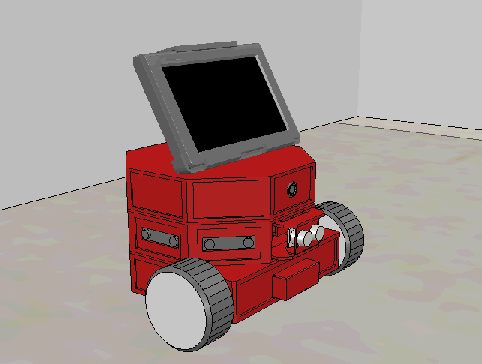

<font color="red"><b>Task 1:</b></font> Download the <b>short_path_vrep.ttt</b> to a working directory where you have saved sim.py, simConst.py (or vrepConst.py) and remoteApi.dll and change your path to that directory.  

In [ ]:
import os
desiredPath = "C:\Users\mahic\Downloads\dir" # set path to working folder
os.chdir(desiredPath)
print("Current working directory: {}".format(os.getcwd()))   # sanity check

<font color="red"><b>Task 2:</b></font> Load the other libraries we are going to use for this workshop <i>Note: This week we will also be making use of numpy otherwise this will be a very short workshop!!</i>.  

In [ ]:
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time
import sys
import numpy as np  # used for the camera data

## choose the correct version of the library to import  
if os.path.isfile('/'.join([desiredPath, 'vrepConst.py'])):
    import vrepConst as wlvConst
else:
    import simConst as wlvConst

<font color="red"><b>Task 3:</b></font> Below is a wrapper class for the dr20 robot. <i>It is complete enough for this weeks workshop but may need more work to use the full set of sensors on the robot</i>. 

In [ ]:
class Dr20Robot_Interface:

    def __init__(self, sim, clientID):
        self._sim = sim
        self.clientID = clientID
        err, self.robHandle = sim.simxGetObjectHandle(clientID, "dr20", sim.simx_opmode_oneshot_wait )
        if err > 0:
            print("*** Error getting robot handle {}".format(err))
        ## attach actuators and sensors
        ## The robot has two senors a front bumper "dr12_bumperForceSensor_" and a camera "Vision_sensor0"
        ## and two actuators left motor "dr12_leftJoint_" and a right motor "dr12_rightJoint_"
        errCode = [0] * 7
        ## attach actuators and sensors
        errCode[0], self.leftMotor = sim.simxGetObjectHandle(clientID, "dr20_leftWheelJoint_", sim.simx_opmode_oneshot_wait )
        errCode[1], self.rightMotor = sim.simxGetObjectHandle(clientID, "dr20_rightWheelJoint_", sim.simx_opmode_oneshot_wait )

        errCode[2], self.infrared1 = sim.simxGetObjectHandle(clientID, "dr20_infraredSensor1_", sim.simx_opmode_oneshot_wait )
        errCode[3], self.infrared2 = sim.simxGetObjectHandle(clientID, "dr20_infraredSensor2_", sim.simx_opmode_oneshot_wait )
        errCode[4], self.infrared5 = sim.simxGetObjectHandle(clientID, "dr20_infraredSensor5_", sim.simx_opmode_oneshot_wait )
        errCode[5], self.infrared6 = sim.simxGetObjectHandle(clientID, "dr20_infraredSensor6_", sim.simx_opmode_oneshot_wait )
        errCode[6], self.ultasonic = sim.simxGetObjectHandle(clientID, "dr20_ultrasonicSensor_", sim.simx_opmode_oneshot_wait )

        if sum(errCode) > 0:
            print("*** Error initialising robot {}".format(errCode))

        ## initialise sensors - needs an initial call to fill the sensor buffer
        for _ in range(10):
            err_code,detectionState,detectedPoint,detectedObjectHandle, detectedSurfaceNormalVector=sim.simxReadProximitySensor(clientID,self.infrared1,sim.simx_opmode_streaming)
            err_code,detectionState,detectedPoint,detectedObjectHandle, detectedSurfaceNormalVector=sim.simxReadProximitySensor(clientID,self.infrared2,sim.simx_opmode_streaming)
            err_code,detectionState,detectedPoint,detectedObjectHandle, detectedSurfaceNormalVector=sim.simxReadProximitySensor(clientID,self.infrared5,sim.simx_opmode_streaming)
            err_code,detectionState,detectedPoint,detectedObjectHandle, detectedSurfaceNormalVector=sim.simxReadProximitySensor(clientID,self.infrared6,sim.simx_opmode_streaming)
            err_code,detectionState,detectedPoint,detectedObjectHandle, detectedSurfaceNormalVector=sim.simxReadProximitySensor(clientID,self.ultasonic,sim.simx_opmode_streaming)
            err_code, property = self._sim.simxGetModelProperty(clientID, self.robHandle, sim.simx_opmode_streaming)

        ## set up some robot constants
        self.v0=0.4 ## *s
        self.wheelDiameter=0.085 ## *s
        self.interWheelDistance=0.254 ## *s
        self.noDetectionDistance=1.0 ## *s
        self.viewSensors = False
        ## Braitenberg weights:
        self.brait_left = [0,-0.5,-1.25,-1,-0.2]

    def rotate_right(self, speed=2.0, distance=None):
        if distance is None:
            self._set_two_motor(speed, -speed)
        else:
            duration = distance/speed
            self._set_two_motor(speed, -speed)
            time.sleep(duration)
            self.stop()

    def rotate_left(self, speed=2.0, distance=None):
        if distance is None:
            self._set_two_motor(-speed, speed)
        else:
            duration = distance/speed
            self._set_two_motor(-speed, speed)
            time.sleep(duration)
            self.stop()


    def move_forward(self, speed=2.0, distance=None):
        if distance is None:
            self._set_two_motor(speed, speed)
        else:
            duration = distance/speed
            self._set_two_motor(speed, speed)
            time.sleep(duration)
            self.stop()

    def move_backward(self, speed=2.0, distance=None):
        ## move the robot backwards
        if distance is None:
            self._set_two_motor(-speed, -speed)
        else:
            duration = distance/speed
            self._set_two_motor(-speed, -speed)
            time.sleep(duration)
            self.stop()

    def _set_two_motor(self, left: float, right: float):
        ## set the left motor to the to the value in left,
        ## the right motor to the value in right
        self._sim.simxSetJointTargetVelocity(self.clientID, self.leftMotor, left, self._sim.simx_opmode_blocking )
        self._sim.simxSetJointTargetVelocity(self.clientID, self.rightMotor, right, self._sim.simx_opmode_blocking )

    def stop(self):
        self._set_two_motor(0.0, 0.0)

    def _readSensor(self, sensorHandle, sensorType):
        if sensorType == wlvConst.sim_object_forcesensor_type:
            result, s, f, t = self._sim.simxReadForceSensor(self.clientID, sensorHandle, self._sim.simx_opmode_blocking)
            return s, f, t
        elif sensorType == wlvConst.sim_object_proximitysensor_type:
            err_code,detectionState,detectedPoint,detectedObjectHandle, detectedSurfaceNormalVecto = self._sim.simxReadProximitySensor(self.clientID, sensorHandle, self._sim.simx_opmode_buffer)
            distance = np.linalg.norm(detectedPoint)
            if err_code == 0 and detectionState == True:
                return wlvConst.simx_return_ok, distance
            return 1, self.noDetectionDistance
        elif sensorType == wlvConst.sim_object_visionsensor_type:
            result, s, auxPackets = self._sim.simxReadVisionSensor(self.clientID, sensorHandle, self._sim.simx_opmode_blocking)
            raw_image = auxPackets[::-1]  ## flip the values to RGB
            backImage = np.array(raw_image, dtype=np.uint8)
            backImage.resize([resolution[0],resolution[0],3])
            image = np.flip(backImage, 0) ## (un)reverse the image, as it is reversed
            return s, image
        else:
            raise Exception('Unknow sensor type {} in _readSensor'.format(sensorType))

    def readSensors(self):
        sensReading = [self.noDetectionDistance,
                       self.noDetectionDistance,
                       self.noDetectionDistance,
                       self.noDetectionDistance,
                       self.noDetectionDistance]
        ## Read the sensors:
        err, dist = self._readSensor(self.infrared5, wlvConst.sim_object_proximitysensor_type)
        sensReading[0] = dist if (err == wlvConst.simx_return_ok) and (dist < self.noDetectionDistance) else self.noDetectionDistance

        err, dist = self._readSensor(self.infrared6, wlvConst.sim_object_proximitysensor_type)
        sensReading[1] = dist if (err == wlvConst.simx_return_ok) and (dist < self.noDetectionDistance) else self.noDetectionDistance

        err, dist = self._readSensor(self.ultasonic, wlvConst.sim_object_proximitysensor_type)
        sensReading[2] = dist if (err == wlvConst.simx_return_ok) and (dist < self.noDetectionDistance) else self.noDetectionDistance

        err, dist = self._readSensor(self.infrared1, wlvConst.sim_object_proximitysensor_type)
        sensReading[3] = dist if (err == wlvConst.simx_return_ok) and (dist < self.noDetectionDistance) else self.noDetectionDistance

        err, dist = self._readSensor(self.infrared2, wlvConst.sim_object_proximitysensor_type)
        sensReading[4] = dist if (err == wlvConst.simx_return_ok) and (dist < self.noDetectionDistance) else self.noDetectionDistance
        return sensReading

    def robotBehaviour(self):
        assert False, "This is the abstract robotBehaviour method, you should inherit and override this method"


I am using OO design here (inheritance and overriding) to expose the robotBehaviour for modification. At the moment the robotBehaviour method implements a Braitenberg algorithm (Google it!!) for demonstration purposes only.  The Braitenberg algorithm is not smart enough to solve the task so <b>you may freely remove, modify or experiment with the robot behaviour by editing the robotBehaviour method</b> without the need to make too many changes to the <i>Dr20Robot_Interface</i> class. 

<font color="red"><b>Task 4:</b></font> This is the main loop of the program it connects to v-rep/CoppeliaSim, creats the bot and runs the whole thing for a fixed number of iterations.

In [12]:
def shortPathMain(viewSensors=False, iterations = 350):
    print ('Program started')
    sim.simxFinish(-1) # just in case, close all opened connections

    clientID=sim.simxStart('127.0.0.1',19997,True,True,5000,5) # Connect to CoppeliaSim

    if clientID != -1:
        print ('Connected to remote API server')
    else:
        print('Connection failed!!')
        sys.exit('Could not connect')

    ## Create the robot object
    bot = Dr20Robot(sim, clientID)
    bot.viewSensors = viewSensors  # yeah - setters are for Java jockeys!!

    ## Run the robot loop
    for _ in range(iterations):
        bot.robotBehaviour()
        time.sleep(1.0)

    ## Stop the robot
    bot.stop()
    time.sleep(0.5)    ## delay to execute the command
    sim.simxFinish(-1) ## just in case, close all opened connections
    print("...done")

Remember to <b>run the v-rep/CoppeliaSim scene first</b> and then run the cell below.

In [13]:
class Dr20Robot(Dr20Robot_Interface):
    def __init__(self, sim, clientID):
        super().__init__(sim, clientID)

    def robotBehaviour(self):
        # Read sensor data
        sensReading = self.readSensors()
        first_left = sensReading[0]
        back_left = sensReading[1]
        middle_sensor= sensReading[2]
        first_right = sensReading[3]
        back_left = sensReading[4]
        
        if middle_sensor < 0.9:
            self.stop()
            if first_left < first_right:
                self.rotate_right(2)
            if first_right < first_left:
                self.rotate_left(2)
        else:
            self.move_forward(8)
            
            

In [14]:
viewSensors = False ## You might want to change this while debugging to see what the robot can see!!!
try:
    shortPathMain(viewSensors)
except Exception as ex:
    print("Exception was: {}".format(ex))
    sim.simxFinish(-1) ## just in case, close all opened connections
    print("...uh oh, something went wrong!!!")

Program started
Connected to remote API server
...done


## <div class="alert alert-block alert-danger">That is the end for this workbook. When you shutdown CoppeliaSim it will offer you the opportunity to save changes, select <b>No</b>. And remember to save your workbook before you shutdown. Next week: we will look at adding even more intelligent behaviour to our robot design. </div>